# Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
import tensorflow as tf
from keras import layers, Model, Sequential, optimizers, losses, datasets, Input

# Params

In [53]:
LATENT_DIM = int(10e2)
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 2**14
EPOCHS = 100

# Generator

In [54]:
class Generator(Model):
    def __init__(self, latent_dim, image_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.image_shape = image_shape  # Сохраняем форму изображения

        # Вычисляем общий размер для выходного слоя
        self.output_size = np.prod(image_shape)

        # Определение слоев
        self.dense1 = layers.Dense(256)
        self.leaky_relu1 = layers.LeakyReLU(negative_slope=0.2)
        self.bn1 = layers.BatchNormalization(momentum=0.8)

        self.dense2 = layers.Dense(512)
        self.leaky_relu2 = layers.LeakyReLU(negative_slope=0.2)
        self.bn2 = layers.BatchNormalization(momentum=0.8)

        self.dense3 = layers.Dense(1024)
        self.leaky_relu3 = layers.LeakyReLU(negative_slope=0.2)
        self.bn3 = layers.BatchNormalization(momentum=0.8)

        # Выходной слой с динамическим размером
        self.output_layer = layers.Dense(self.output_size, activation="sigmoid")
        self.reshape = layers.Reshape(self.image_shape)

    def call(self, inputs, training=None):
        x = self.dense1(inputs)
        x = self.leaky_relu1(x)
        x = self.bn1(x, training=training)

        x = self.dense2(x)
        x = self.leaky_relu2(x)
        x = self.bn2(x, training=training)

        x = self.dense3(x)
        x = self.leaky_relu3(x)
        x = self.bn3(x, training=training)

        x = self.output_layer(x)
        return self.reshape(x)

    def build_model(self):
        x = Input(shape=(self.latent_dim,))
        return Model(inputs=[x], outputs=self.call(x))

In [55]:
generator = Generator(LATENT_DIM, IMG_SHAPE)
generator.build_model().summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,920 (6.58 MB)

 Trainable params: 1,720,336 (6.56 MB)

 Non-trainable params: 3,584 (14.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


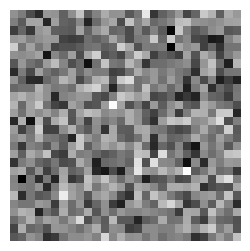

In [56]:
def generate_sample(generator, latent_dim, image_shape):
    noise = np.random.normal(0, 1, (1, latent_dim))
    generated_image = generator.predict(noise, verbose="auto")

    plt.figure(figsize=(3, 3))
    if image_shape[-1] == 1:  # Градации серого
        plt.imshow(generated_image[0, :, :, 0], cmap="gray")
    else:  # RGB или другие форматы
        plt.imshow((generated_image[0] * 255).astype(np.uint8))
    plt.axis("off")
    plt.show()


img = generate_sample(generator, LATENT_DIM, IMG_SHAPE)

# Discriminator

In [57]:
class Discriminator(Model):
    def __init__(self, img_shape):
        super().__init__()
        self.img_shape = img_shape
        
        self.flatten = layers.Flatten(input_shape=img_shape)
        self.dense1 = layers.Dense(512)
        self.leaky_relu1 = layers.LeakyReLU(0.2)
        self.dense2 = layers.Dense(256)
        self.leaky_relu2 = layers.LeakyReLU(0.2)
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.leaky_relu1(x)
        x = self.dense2(x)
        x = self.leaky_relu2(x)
        return self.output_layer(x)

    def build_model(self):
        # Метод для явной инициализации и проверки архитектуры
        x = Input(shape=self.img_shape)
        return Model(inputs=[x], outputs=self.call(x))

In [58]:
# Создание дискриминатора
discriminator = Discriminator(IMG_SHAPE)

# Инициализация весов (опционально, но рекомендуется)
discriminator.build_model().summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

# GAN

In [59]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # Генерация шума
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, LATENT_DIM])

        # Генерация фейковых изображений
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            # Предсказания для реальных и фейковых изображений
            real_pred = self.discriminator(real_images, training=True)
            fake_pred = self.discriminator(generated_images, training=True)

            # Вычисление потерь
            d_real_loss = self.loss_fn(tf.ones_like(real_pred), real_pred)
            d_fake_loss = self.loss_fn(tf.zeros_like(fake_pred), fake_pred)
            d_loss = (d_real_loss + d_fake_loss) * 0.5

            g_loss = self.loss_fn(tf.ones_like(fake_pred), fake_pred)

        # Обновление весов
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )

        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, self.generator.trainable_variables)
        )
        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables)
        )

        return {"d_loss": d_loss, "g_loss": g_loss}

    def predict(self, noise):
        # Генерация изображений по шуму
        return self.generator(noise, training=False)

# Train

In [60]:
def generate_images(model: Model, epoch: int | str, image_path: str = None, num_examples: int = 10):
    noise = tf.random.normal([num_examples, LATENT_DIM])
    generated = model.predict(noise)

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated[i, :, :, 0], cmap="gray")
        plt.axis("off")
    if image_path is not None:
        plt.savefig(f"{image_path}/gan_generated_epoch_{epoch}.png")
    else:
        plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.close()

In [61]:
def plot_images(model, num_examples: int = 10):
    noise = tf.random.normal([num_examples, LATENT_DIM])
    generated = model.predict(noise)

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.show()

In [62]:
generator = Generator(LATENT_DIM, IMG_SHAPE).build_model()
discriminator = Discriminator(IMG_SHAPE).build_model()

# Компиляция GAN
gan = GAN(generator, discriminator)
gan.compile(
    g_optimizer=optimizers.Adam(0.0002, 0.5),
    d_optimizer=optimizers.Adam(0.0002, 0.5),
    loss_fn=losses.BinaryCrossentropy(),
)

In [63]:
(x_train, _), (_, _) = datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 0.5) * 2
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(BATCH_SIZE)

In [64]:
x_train.shape

(60000, 28, 28, 1)

In [65]:
count_batches = len(dataset)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    for index, batch in enumerate(dataset):
        print(f"batch {index + 1} out of {count_batches}")
        gan.train_step(batch)

    # Генерация примеров каждые 10 эпох
    # if (epoch + 1) % 10 == 0:
    generate_images(gan, epoch + 1, "images")
    print()

Epoch 1/100
batch 1 out of 4


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_119']
Received: inputs=Tensor(shape=(16384, 1000))
  warnings.warn(msg)
d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_131']
Received: inputs=Tensor(shape=(16384, 28, 28, 1))
  warnings.warn(msg)


batch 2 out of 4
batch 3 out of 4


KeyboardInterrupt: 

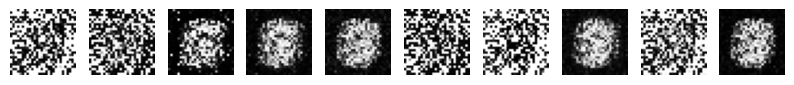

In [ ]:
generate_images(gan, "final")

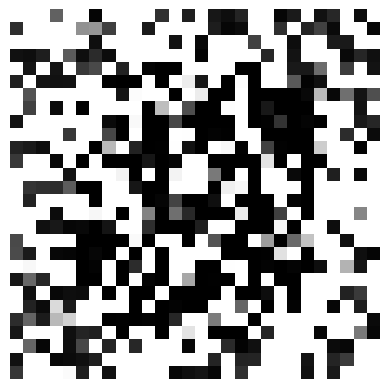

In [ ]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = gan.predict(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()